### Use a SOM to construct feature likelihood

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import sys
sys.path.append('../python')

import os
import som
import time
import seaborn as sns
import pandas as pd

from astropy.table import Table

In [4]:
from GCR import GCRQuery
import GCRCatalogs

Define global variables:

In [5]:
rng = np.random.RandomState(seed=14)
res = -100

#### Generate SOM using random data

In [5]:
n_deep = int(131e3)
n_phot = 500000

rndm_deep = rng.uniform(high=10.0, size=(n_deep,3))
rndm_phot = rng.uniform(high=10.0, size=(n_phot,3))
## Generate 'target feature' (i.e. redshift) values that are correlated with the photometric sample in some way
## Will see a degeneracy in the map when sampling based on mean of all the features
rndm_z = rng.normal(loc=np.mean(rndm_phot.view(float), axis=1), scale=0.5 * np.std(rndm_phot))

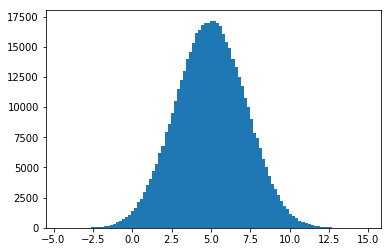

In [6]:
plt.hist(rndm_z, bins=100)
plt.show()

In [7]:
rndm_deep_df = pd.DataFrame(rndm_deep, columns=('x', 'y', 'z'))
rndm_phot_df = pd.DataFrame(rndm_phot, columns=('x', 'y', 'z'))

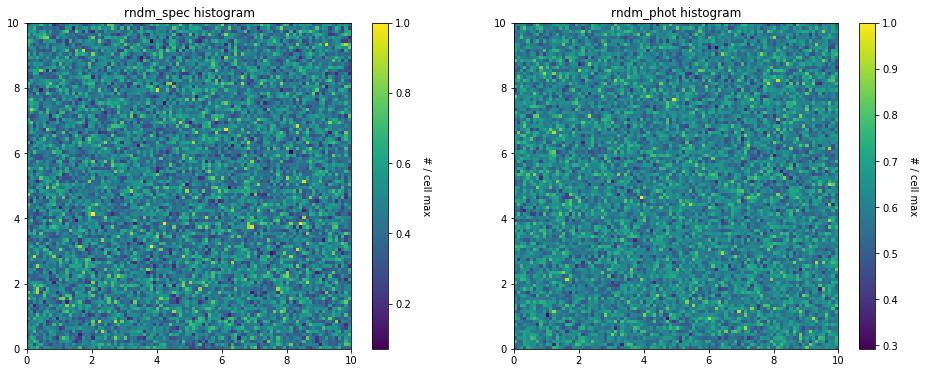

In [8]:
som.deep_phot_hist2d(rndm_deep_df, rndm_phot_df, cols=['x', 'y'], bins=np.abs(res))

158.82600831985474


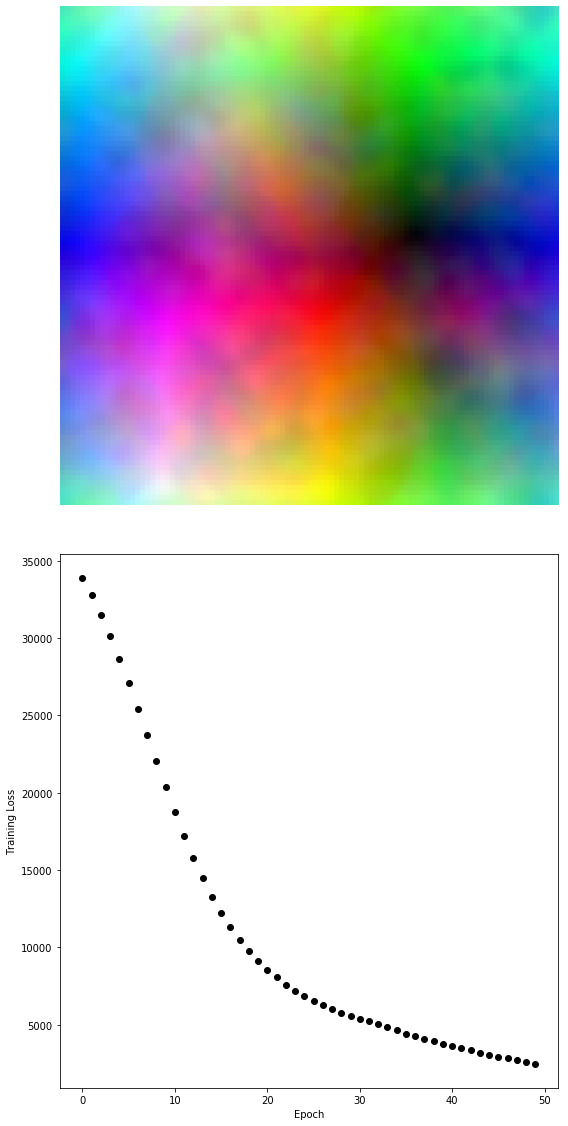

In [9]:
start = time.time()
rndm_som = som.make_som(rndm_deep[::15], nmap=res, niter=50, rgb=[0,1,2])
print(time.time() - start)

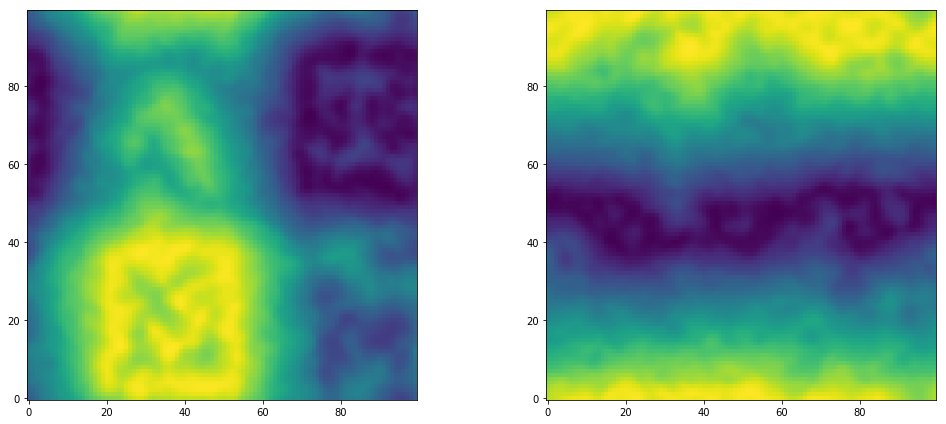

In [10]:
fig, axs = plt.subplots(1,2,figsize=(15,6))
axs = axs.ravel()

for i in range(2):
    axs[i].imshow(rndm_som[:,:,i], origin='lower', interpolation='none')
    
plt.tight_layout()
plt.show()

Make a histogram of weight values for deep sample, photometric sample, and SOM:

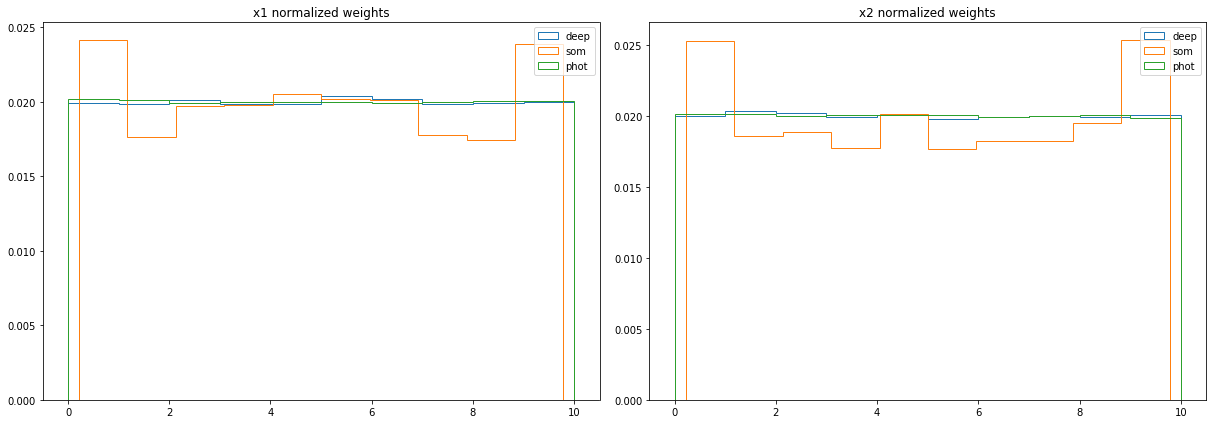

In [11]:
fig, axs = plt.subplots(1,2, figsize=(17,6))
axs = axs.ravel()

rows, cols, D = rndm_som.shape

axs[0].hist(rndm_deep[:,0], weights=np.ones(len(rndm_deep)) / np.sum(rndm_deep[:,0]), histtype='step', label='deep')
axs[0].hist(rndm_som.reshape(rows * cols, D)[:,0], weights=np.ones(rows * cols) / np.sum(rndm_som.reshape(rows * cols, D)[:,0]), histtype='step', label='som')
axs[0].hist(rndm_phot[:,0], weights=np.ones(len(rndm_phot)) / np.sum(rndm_phot[:,0]), histtype='step', label='phot')
axs[0].set_title('x1 normalized weights')
axs[0].legend()

axs[1].hist(rndm_deep[:,1], weights=np.ones(len(rndm_deep)) / np.sum(rndm_deep[:,1]), histtype='step', label='deep')
axs[1].hist(rndm_som.reshape(rows * cols, D)[:,1], weights=np.ones(rows * cols) / np.sum(rndm_som.reshape(rows * cols, D)[:,1]), histtype='step', label='som')
axs[1].hist(rndm_phot[:,1], weights=np.ones(len(rndm_phot)) / np.sum(rndm_phot[:,1]), histtype='step', label='phot')
axs[1].set_title('x2 normalized weights')
axs[1].legend()

plt.tight_layout()
plt.show()

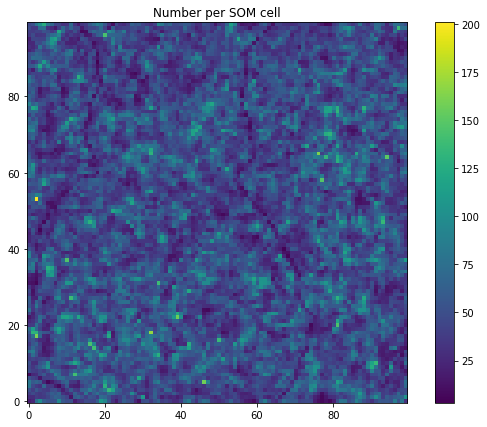

In [12]:
rows, cols, D = rndm_som.shape
som_indices, counts = som.map_phot_to_som(rndm_phot, rndm_som)
som.plot_counts_per_cell(som_indices, counts, rows, cols)

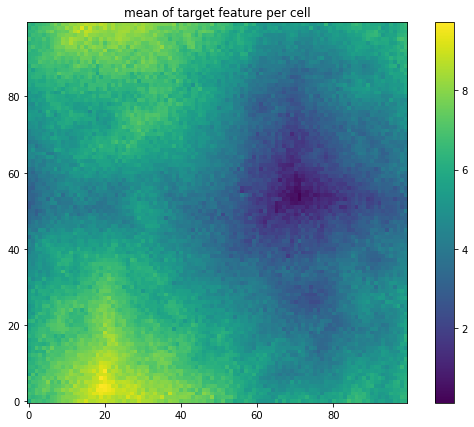

In [13]:
som.plot_statistic(som_indices, counts, rndm_z, rows, cols, statistic=np.mean)

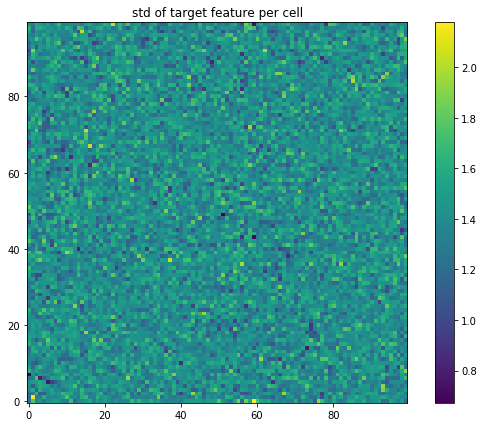

In [14]:
som.plot_statistic(som_indices, counts, rndm_z, rows, cols, statistic=np.std)

###### to do: plot SED as a function of central wavelength in each filter band

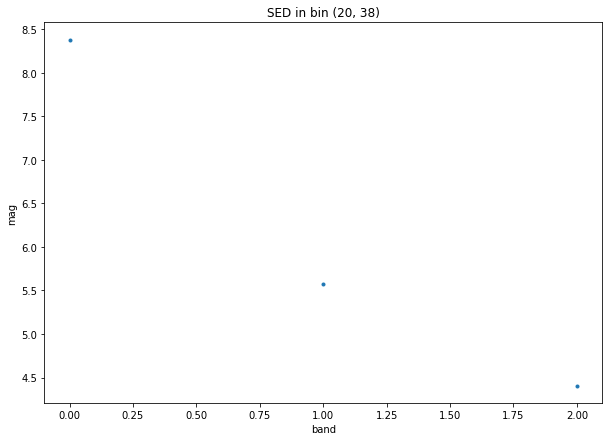

In [15]:
som.plot_sed_in_cell(rndm_phot, som_indices, cols, rng, idx=(20,38))

#### Load cosmoDC2 data

If running for the first time, access the data via the GCR. Otherwise reload an existing copy of the data.

In [6]:
reload = True

In [7]:
if not reload:

    gc = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_small')

    # Define coordinate cuts

    # 4 x 4 sq deg patch
    deg = 4 
    # alpha = cos<DEC>, where DEC is the average declination of our patch
    alpha = 0.78 
    beta = (0.5 * deg) * (1/alpha - 1)

    ra_min = 62.5 - beta
    ra_max = 66.5 + beta
    dec_min = -41.
    dec_max = -37.

    coord_filters = [
        'ra >= {}'.format(ra_min),
        'ra < {}'.format(ra_max),
        'dec >= {}'.format(dec_min),
        'dec < {}'.format(dec_max),
    ]

    # Define magnitude cuts

    mag_filters = [
        'mag_r < 26.3',
        'mag_i < 26.3',
    ]

    # Apply all cuts
    gc_data_mag_cut = gc.get_quantities(['ra', 'dec', 'redshift', 'mag_i', 'mag_g', 'mag_r', 'mag_u', 'mag_y', 
                                         'mag_z'], filters=(coord_filters + mag_filters))

    u = gc_data_mag_cut['mag_u']
    g = gc_data_mag_cut['mag_g']
    r = gc_data_mag_cut['mag_r']
    i = gc_data_mag_cut['mag_i']
    z = gc_data_mag_cut['mag_z']
    y = gc_data_mag_cut['mag_y']

    u_g = u - g
    g_r = g - r
    r_i = r - i
    i_z = i - z
    z_y = z - y

    redshift = gc_data_mag_cut['redshift']
    colors = np.asarray([u_g, g_r, r_i, i_z, z_y]).T
    mags = np.asarray([u, g, r, i, z, y]).T

    mags_table = Table(mags, names=['u', 'g', 'r', 'i', 'z', 'y'])
    colors_table = Table(colors, names=['u-g', 'g-r', 'r-i', 'i-z', 'z-y'])
    redshift_table = Table(redshift.reshape(-1,1), names=['redshift'])

    overwrite = True
    mags_table.write('../data/feature_likelihood/dc2_mags.fits', format='fits', overwrite=overwrite)
    colors_table.write('../data/feature_likelihood/dc2_colors.fits', format='fits', overwrite=overwrite)
    redshift_table.write('../data/feature_likelihood/dc2_redshift.fits', format='fits', overwrite=overwrite)

In [8]:
if reload: 
    mags = Table.read('../data/feature_likelihood/dc2_mags.fits', format='fits')
    colors = Table.read('../data/feature_likelihood/dc2_colors.fits', format='fits')
    redshift = Table.read('../data/feature_likelihood/dc2_redshift.fits', format='fits')
    assert len(mags) == len(colors) == len(redshift)

#### DC2 Diagnostic Plots

In [20]:
def prepare_deep_phot_chunks(colors, mags, redshifts, n_deep, n_phot, rng=rng):
    
    assert len(colors) == len(mags) == len(redshifts)
    
    ## Randomly select galaxies for each sample
    indices = np.arange(len(colors))
    rng.shuffle(indices)
    
    deep_colors = colors[indices[:n_deep]]
    deep_mags = mags[indices[:n_deep]]
    deep_z = redshifts[indices[:n_deep]]
    
    phot_colors = colors[indices[n_deep:n_deep + n_phot]]
    phot_mags = mags[indices[n_deep:n_deep + n_phot]]
    phot_z = redshifts[indices[n_deep:n_deep + n_phot]]
    
    return(deep_colors, deep_mags, deep_z, phot_colors, phot_mags, phot_z)


n_deep = int(131e3)
n_phot = int(n_deep / 0.02) # There aren't enough galaxies in the DC2 sample after cuts to make this 2% of the deep sample (closer to 3%)

dc2_deep_colors, dc2_deep_mags, dc2_deep_z, dc2_phot_colors, dc2_phot_mags, dc2_phot_z = prepare_deep_phot_chunks(colors, mags, redshift, n_deep, n_phot)

In [35]:
df = pd.DataFrame(np.asarray(dc2_deep_colors), columns=('u-g', 'g-r', 'r-i', 'i-z', 'z-y'))

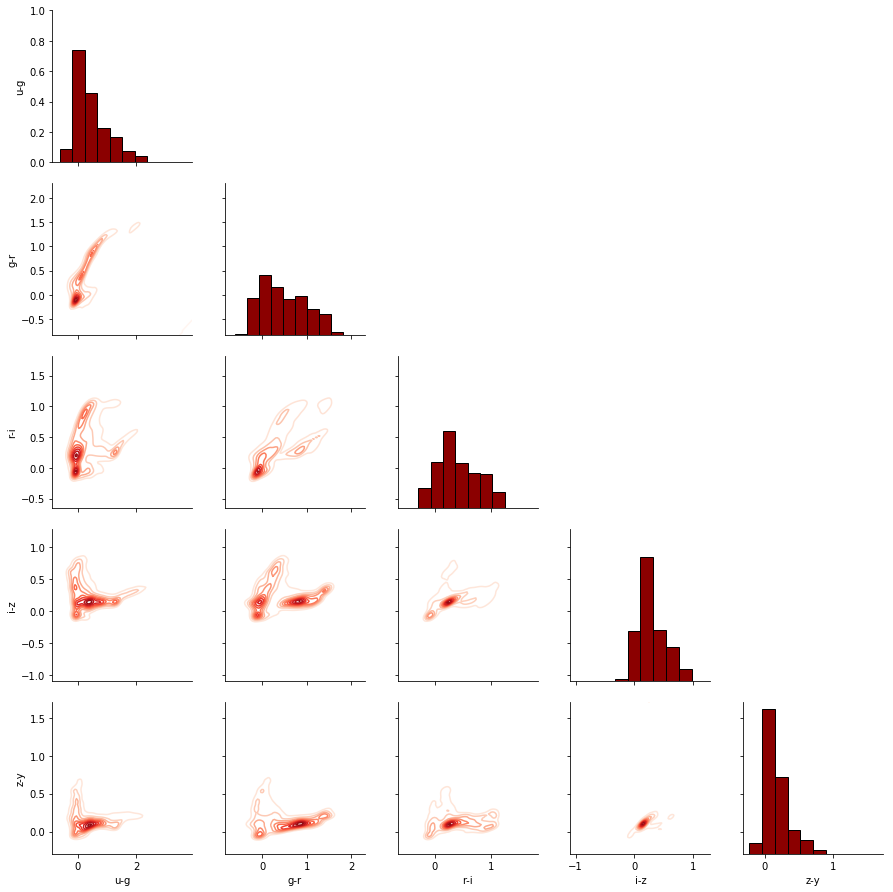

In [37]:
def hide_current_axis(*args, **kwds):
    plt.gca().set_visible(False)
    
grid = sns.PairGrid(data=df)

# Map a histogram to the diagonal
grid = grid.map_diag(plt.hist, bins = 10, color = 'darkred', 
                     edgecolor = 'k')
# Map a density plot to the lower triangle
grid = grid.map_lower(sns.kdeplot, cmap = 'Reds')

grid.map_upper(hide_current_axis)

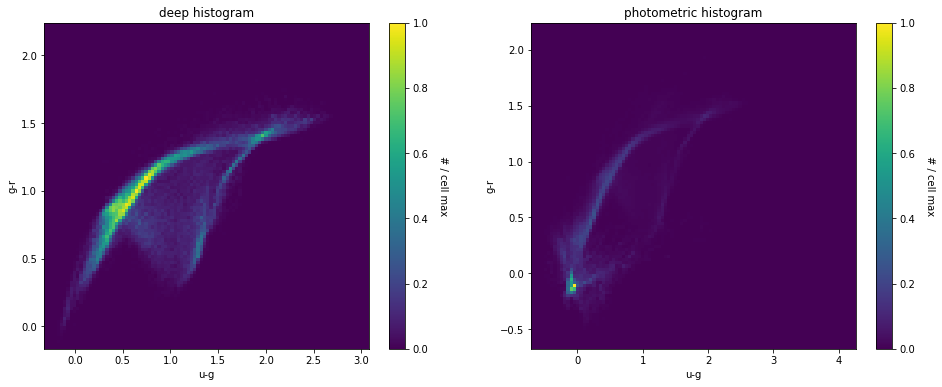

In [11]:
som.deep_phot_hist2d(dc2_deep_colors, dc2_phot_colors, cols=['u-g', 'g-r'], bins=np.abs(res))

195.00037479400635


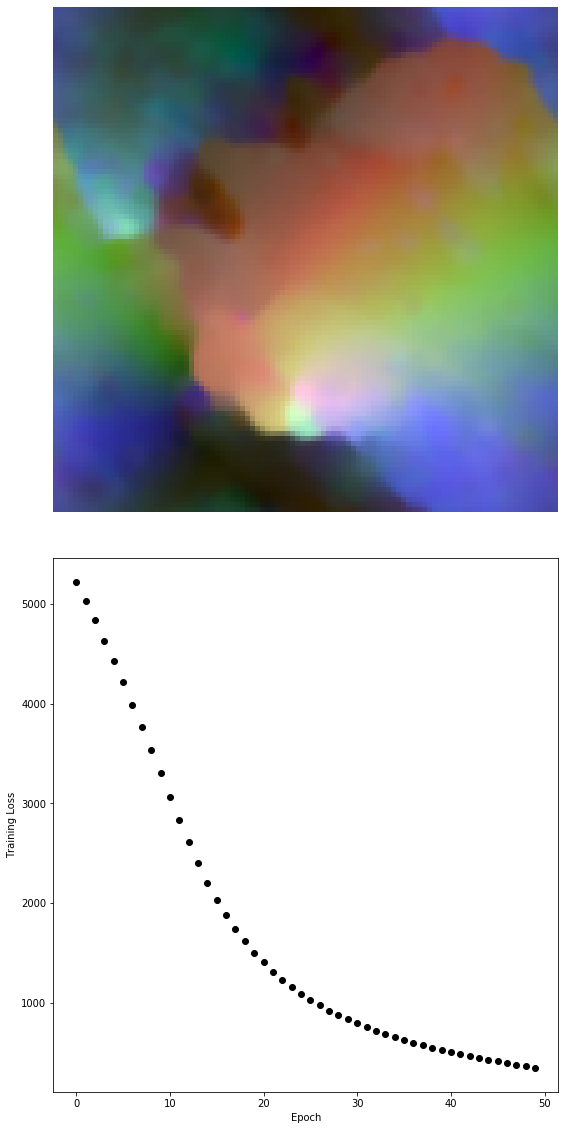

In [45]:
start = time.time()
dc2_som = som.make_som(dc2_deep_colors[::15], nmap=res, niter=50, rgb=[1,2,3])
print(time.time() - start)

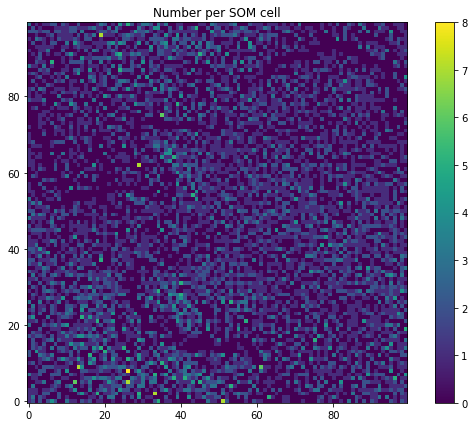

In [50]:
rows, cols, D = dc2_som.shape
som_indices, counts = som.map_data_to_som(dc2_deep_colors[::15], dc2_som)
som.plot_counts_per_cell(som_indices, counts, rows, cols)

### Run at NERSC with full 131k galaxy deep sample

In [23]:
dc2_path = '/global/cscratch1/sd/belaa/lsst/pz/batch_scripts/som_output/'

In [40]:
def load_som_output(colors, mags, redshifts, basename, som_filename, index_filename, losses_filename):
    
    som = np.load(os.path.join(basename, som_filename))
    indices = np.load(os.path.join(basename, index_filename))
    losses = np.load(os.path.join(basename, losses_filename))
    
    return(som, indices, losses, colors[indices], mags[indices], redshifts[indices])
    
## Load SOM with periodic boundary conditions and the indices of the galaxies in the original dc2 table that were selected to make this SOM
dc2_som_periodic, dc2_indices_periodic, dc2_losses_periodic, selected_colors_periodic, selected_mags_periodic, selected_z_periodic = load_som_output(colors, mags, redshift, basename=dc2_path, 
                                                                                                                                som_filename='dc2_som_131000_100_periodic.npy', 
                                                                                                                                index_filename='dc2_random_idx_131000_100_periodic.npy', 
                                                                                                                                losses_filename='dc2_som_131000_100_periodic_losses.npy')
## Do same but for non-periodic boundary conditions
dc2_som_nonperiodic, dc2_indices_nonperiodic, dc2_losses_nonperiodic, selected_colors_nonperiodic, selected_mags_nonperiodic, selected_z_nonperiodic = load_som_output(colors, mags, redshift, basename=dc2_path, 
                                                                                                                                               som_filename='dc2_som_131000_100_nonperiodic.npy', 
                                                                                                                                               index_filename='dc2_random_idx_131000_100_nonperiodic.npy', 
                                                                                                                                               losses_filename='dc2_som_131000_100_nonperiodic_losses.npy')

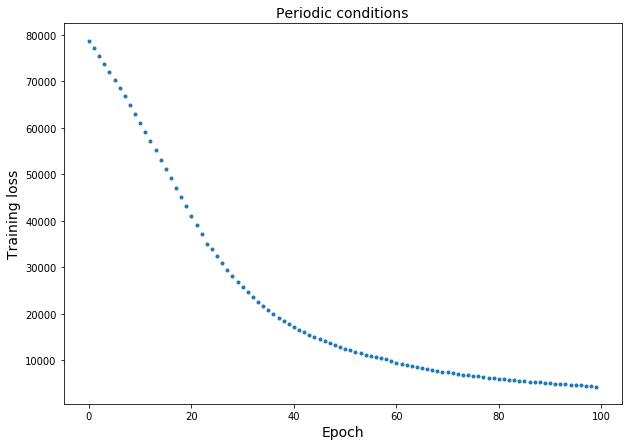

In [44]:
fs = 14
plt.figure(figsize=(10,7))
plt.plot(dc2_losses_periodic, '.')
plt.title('Periodic conditions', fontsize=fs)
plt.xlabel('Epoch', fontsize=fs)
plt.ylabel('Training loss', fontsize=fs)
plt.show()

In [35]:
df = pd.DataFrame(np.asarray(selected_colors_periodic), columns=('u-g', 'g-r', 'r-i', 'i-z', 'z-y'))

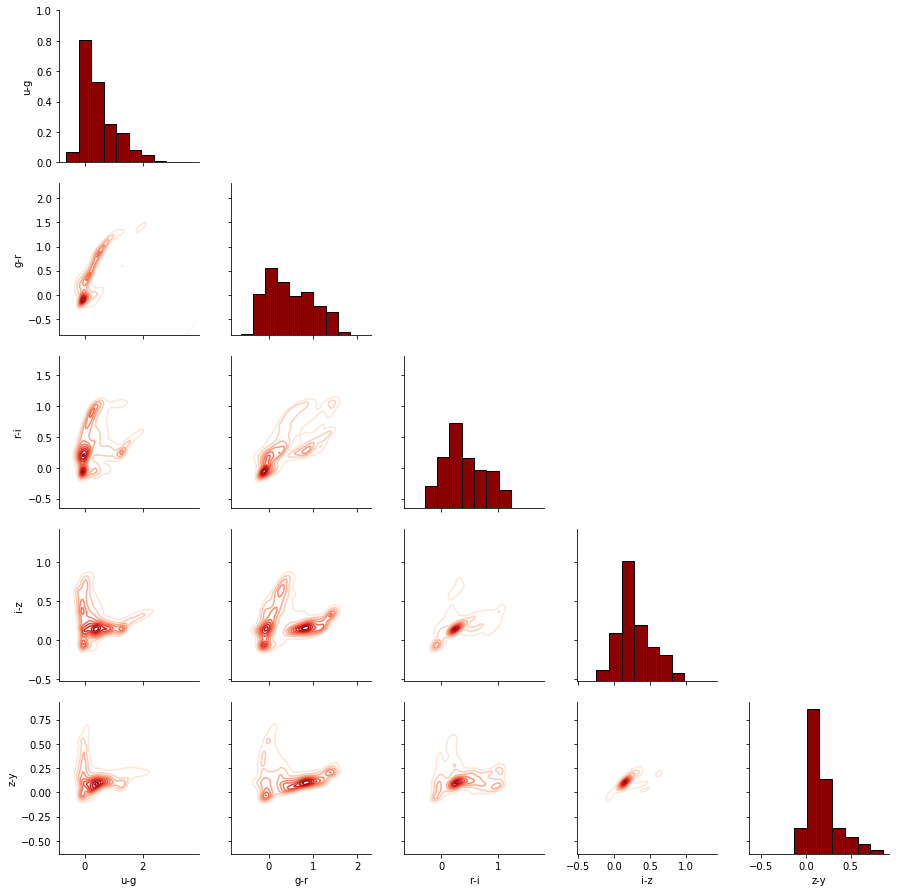

In [36]:
def hide_current_axis(*args, **kwds):
    plt.gca().set_visible(False)
    
grid = sns.PairGrid(data=df)

# Map a histogram to the diagonal
grid = grid.map_diag(plt.hist, bins = 10, color = 'darkred', 
                     edgecolor = 'k')
# Map a density plot to the lower triangle
grid = grid.map_lower(sns.kdeplot, cmap = 'Reds')

grid.map_upper(hide_current_axis)

In [33]:
def rgb_colors(som, rgb):
    
    res = som.shape[0]
    
    img = som.reshape(res ** 2, -1)
    img = (img - img.min(axis=0)) / (img.max(axis=0) - img.min(axis=0))
    rgb_som = np.empty((img.shape[0],3))
    for i, band in enumerate(rgb):
        rgb_som[:,i] = img[:,band]
    rgb_som /= np.max(rgb_som)
    rgb_img = rgb_som.reshape(res, res, 3)
    
    return(rgb_img)

def rgb_mags(som, rgb, **kwargs):
    
    mags = kwargs['mags']
    res = kwargs['res']
        
    rgb_img = np.empty((res ** 2, 3))

    for i in range(res ** 2):

            rgb0 = np.asarray(mags[rgb[0]])[som_indices == i]
            rgb1 = np.asarray(mags[rgb[1]])[som_indices == i]
            rgb2 = np.asarray(mags[rgb[2]])[som_indices == i]

            rgb_img[i, 0] = np.mean(rgb0)
            rgb_img[i, 1] = np.mean(rgb1)
            rgb_img[i, 2] = np.mean(rgb2)

    minn = np.nanmin(rgb_img, axis=0)
    maxx = np.nanmax(rgb_img, axis=0)
    
    rgb_img = (rgb_img - minn) / (maxx - minn)
    return(rgb_img.reshape(abs(res), abs(res), 3))
    
    

def plot_rgb(som, rgb_method=rgb_colors, **kwargs):
    
    if rgb_method == rgb_colors:
        combinations = [[0,1,2], [1,2,3], [2,3,4], [0,2,4]]
        fig, axs = plt.subplots(2,2, figsize=(8,8))
        
    if rgb_method == rgb_mags:
        combinations = [['u', 'g', 'r'], ['g', 'r', 'i'], ['r', 'i', 'z'], ['i', 'z', 'y'], ['u', 'r', 'z'], ['g', 'i', 'y']]
        fig, axs = plt.subplots(2,3, figsize=(8,8))
    
    axs = axs.ravel()
    n = len(combinations)
    
    for i in range(n):
        img = rgb_method(som, combinations[i], **kwargs)
        axs[i].imshow(img, origin='low', interpolation='none')
        axs[i].set_title('{}'.format(combinations[i]))
        
    plt.tight_layout()
    plt.show()

##### 1. Periodic boundary conditions

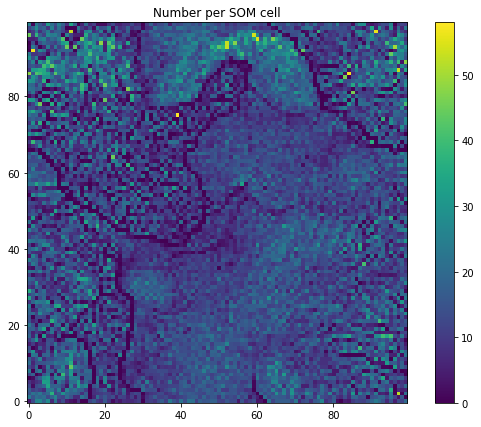

In [68]:
rows, cols, D = dc2_som_periodic.shape
som_indices, counts = som.map_data_to_som(selected_colors_periodic, dc2_som_periodic)
som.plot_counts_per_cell(som_indices, counts, rows, cols)

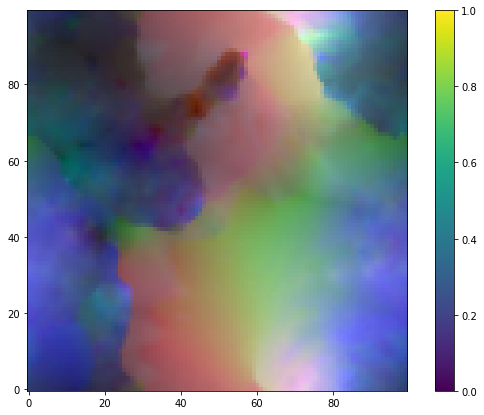

In [53]:
temp1 = rgb_colors(dc2_som_periodic, rgb=[1,2,3])
plt.figure(figsize=(10,7))
plt.imshow(temp1, origin='low', interpolation='none')
plt.colorbar()
plt.show()

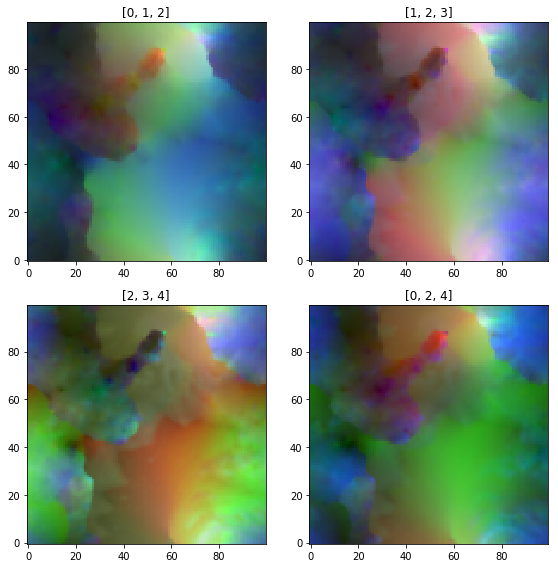

In [13]:
plot_rgb(dc2_som_periodic, rgb_method=rgb_colors)

/opt/lsst/software/stack/python/miniconda3-4.5.12/envs/lsst-scipipe-1172c30/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/lsst/software/stack/python/miniconda3-4.5.12/envs/lsst-scipipe-1172c30/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


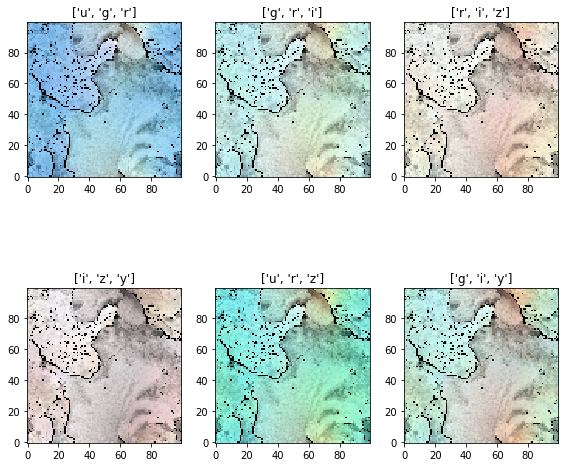

In [14]:
plot_rgb(dc2_som_periodic, rgb_method=rgb_mags, mags=selected_mags_periodic, res=res)

/opt/lsst/software/stack/python/miniconda3-4.5.12/envs/lsst-scipipe-1172c30/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3115: RuntimeWarning: Mean of empty slice.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


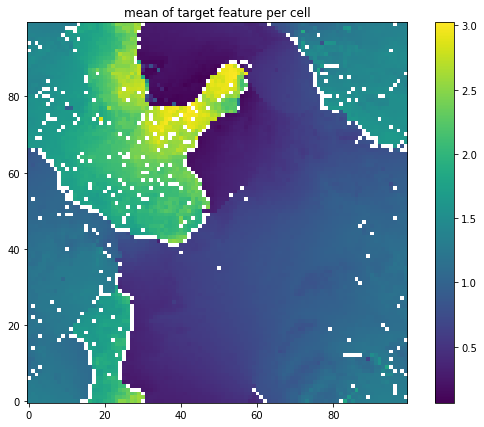

In [16]:
som.plot_statistic(som_indices, counts, selected_z_periodic['redshift'], rows, cols, statistic=np.mean)

/opt/lsst/software/stack/python/miniconda3-4.5.12/envs/lsst-scipipe-1172c30/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/opt/lsst/software/stack/python/miniconda3-4.5.12/envs/lsst-scipipe-1172c30/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/opt/lsst/software/stack/python/miniconda3-4.5.12/envs/lsst-scipipe-1172c30/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


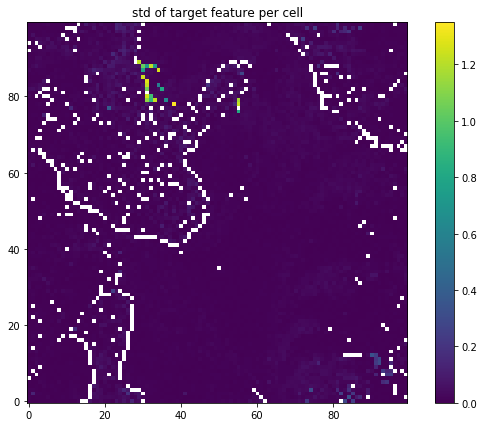

In [17]:
som.plot_statistic(som_indices, counts, selected_z_periodic['redshift'], rows, cols, statistic=np.std)

Fix this so that it works with subplots:

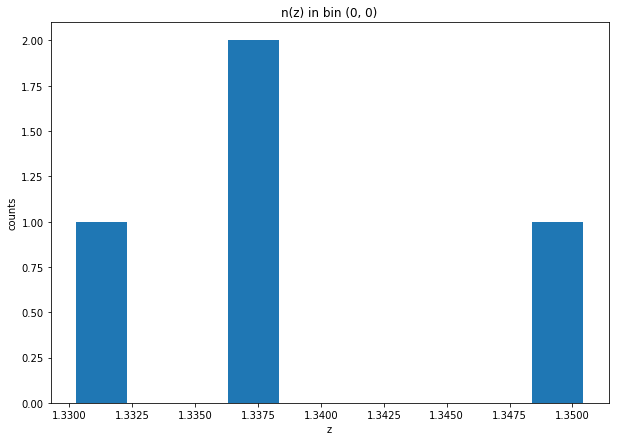

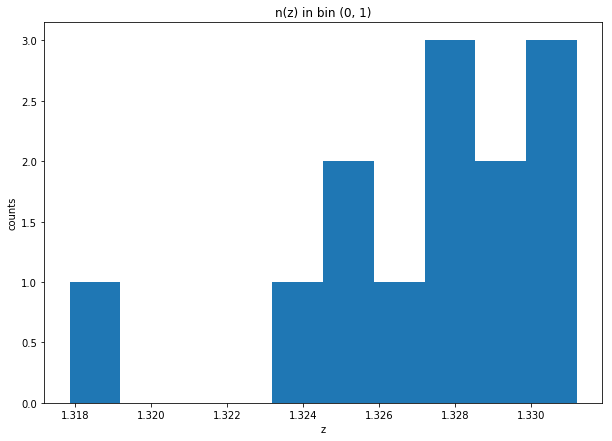

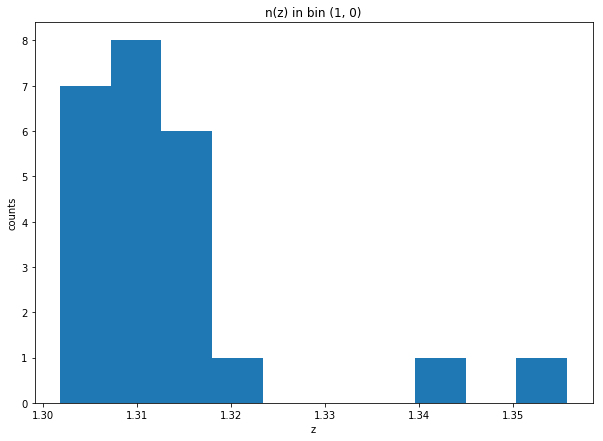

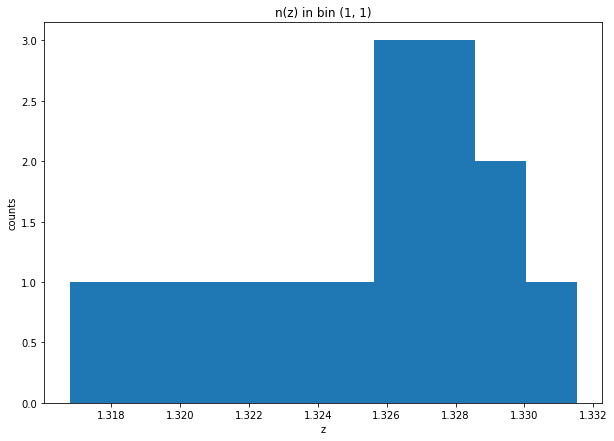

In [15]:
dim = 2

for i in range(dim):
    for j in range(dim):
        som.plot_dist_in_cell(som_indices, selected_z_periodic['redshift'], cols, idx=(i,j))

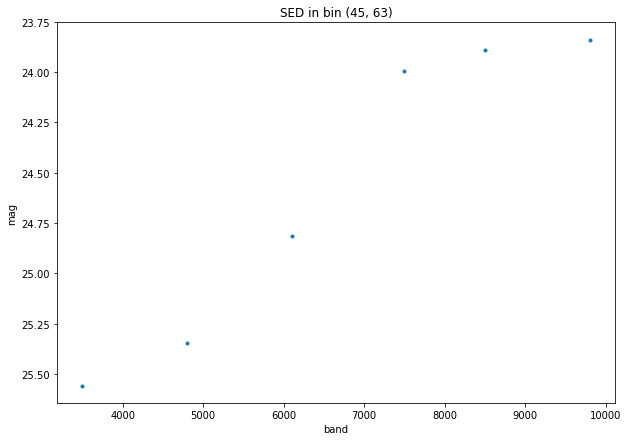

In [19]:
som.plot_sed_in_cell(selected_mags_periodic, som_indices, cols, rng, idx=(45, 63))

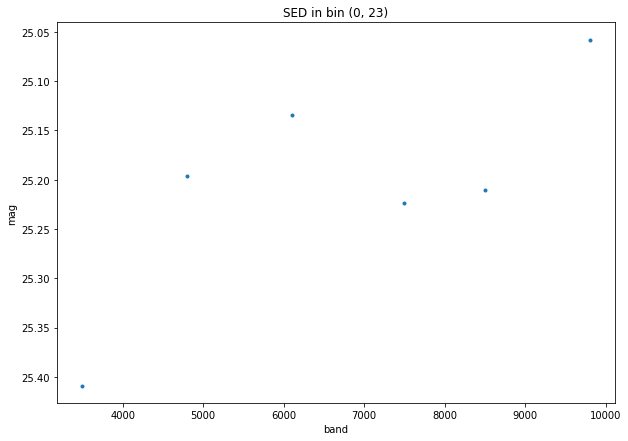

In [18]:
som.plot_sed_in_cell(selected_mags_periodic, som_indices, cols, rng, idx=(0, 23))

In [63]:
def quant_error(data, som_indices, som_weights):
    
    """Average quantization error (from Masters et al. 2015 Eq. 7)"""
    
    data = np.asarray(data)
    data_view = data.view((data.dtype[0], len(data.dtype.names)))
    
    n = len(data)
    
    dx = data_view - som_weights[som_indices,:]
    dist = np.sqrt(np.sum(dx ** 2))
    qe = np.sum(dist, axis=0) / n
    
    return(qe)

In [69]:
quant_error(selected_colors_periodic, som_indices, dc2_som_periodic.reshape(res ** 2, 5))

0.00011163176313478832

In [ ]:
rows, cols, D = dc2_som_periodic.shape
som_indices, counts = som.map_data_to_som(dc2_phot_colors, dc2_som_periodic)
som.plot_counts_per_cell(som_indices, counts, rows, cols)

In [ ]:
quant_error(dc2_phot_colors, som_indices, dc2_som_periodic.reshape(res ** 2, 5))

##### 4. Nonperiodic boundary conditions

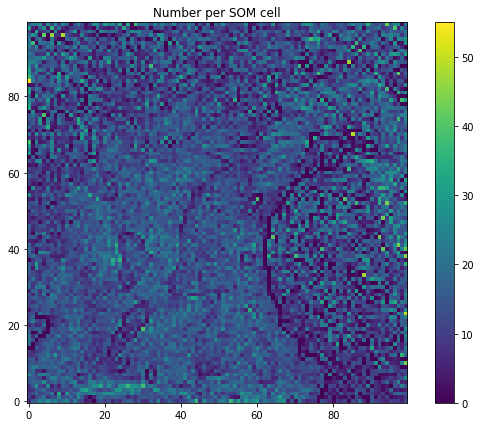

In [20]:
rows, cols, D = dc2_som_periodic.shape
som_indices, counts = som.map_data_to_som(selected_colors_nonperiodic, dc2_som_nonperiodic)
som.plot_counts_per_cell(som_indices, counts, rows, cols)

#### Incorporate errors into SOM

In [54]:
reload = True

In [55]:
if not reload:

    gc_err = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_small_photoz_magerr_10y')

    # Define coordinate cuts

    # 4 x 4 sq deg patch
    deg = 4 
    # alpha = cos<DEC>, where DEC is the average declination of our patch
    alpha = 0.78 
    beta = (0.5 * deg) * (1/alpha - 1)

    ra_min = 62.5 - beta
    ra_max = 66.5 + beta
    dec_min = -41.
    dec_max = -37.

    coord_filters = [
        'ra >= {}'.format(ra_min),
        'ra < {}'.format(ra_max),
        'dec >= {}'.format(dec_min),
        'dec < {}'.format(dec_max),
    ]

    # Define magnitude cuts

    mag_filters = [
        'mag_r < 26.3',
        'mag_i < 26.3',
    ]

    # Apply all cuts
    gc_err_data_mag_cut = gc_errs.get_quantities(['ra', 'dec', 'redshift', 'scatmag_u', 'scaterr_u', 'scatmag_g', 'scaterr_g', 'scatmag_r', 'scaterr_r', 
                                         'scatmag_i', 'scaterr_i', 'scatmag_z', 'scaterr_z', 'scatmag_y', 'scaterr_y'], 
                                        filters=(coord_filters + mag_filters))

    scat_u = gc_err_data_mag_cut['scatmag_u']
    scat_g = gc_err_data_mag_cut['scatmag_g']
    scat_r = gc_err_data_mag_cut['scatmag_r']
    scat_i = gc_err_data_mag_cut['scatmag_i']
    scat_z = gc_err_data_mag_cut['scatmag_z']
    scat_y = gc_err_data_mag_cut['scatmag_y']
    
    scaterr_u = gc_err_data_mag_cut['scaterr_u']
    scaterr_g = gc_err_data_mag_cut['scaterr_g']
    scaterr_r = gc_err_data_mag_cut['scaterr_r']
    scaterr_i = gc_err_data_mag_cut['scaterr_i']
    scaterr_z = gc_err_data_mag_cut['scaterr_z']
    scaterr_y = gc_err_data_mag_cut['scaterr_y']

    u_g = scat_u - scat_g
    g_r = scat_g - scat_r
    r_i = scat_r - scat_i
    i_z = scat_i - scat_z
    z_y = scat_z - scat_y
    
    u_g_err = np.sqrt(scaterr_u ** 2 + scaterr_g ** 2)
    g_r_err = np.sqrt(scaterr_g ** 2 + scaterr_r ** 2)
    r_i_err = np.sqrt(scaterr_r ** 2 + scaterr_i ** 2)
    i_z_err = np.sqrt(scaterr_i ** 2 + scaterr_z ** 2)
    z_y_err = np.sqrt(scaterr_z ** 2 + scaterr_y ** 2)    
    

    redshift = gc_err_data_mag_cut['redshift']
    colors = np.asarray([u_g, g_r, r_i, i_z, z_y]).T
    color_errs = np.asarray([u_g_err, g_r_err, r_i_err, i_z_err, z_y_err]).T
    mags = np.asarray([scat_u, scat_g, scat_r, scat_i, scat_z, scat_y]).T
    mag_errs = np.asarray([scaterr_u, scaterr_g, scaterr_r, scaterr_i, scaterr_z, scaterr_y]).T

    mags_table = Table(mags, names=['u', 'g', 'r', 'i', 'z', 'y'])
    mag_errs_table = Table(mag_errs, names=['u', 'g', 'r', 'i', 'z', 'y'])
    colors_table = Table(colors, names=['u-g', 'g-r', 'r-i', 'i-z', 'z-y'])
    color_errs_table = Table(color_errs, names=['u-g', 'g-r', 'r-i', 'i-z', 'z-y'])
    redshift_table = Table(redshift.reshape(-1,1), names=['redshift'])

    overwrite = True
    mags_table.write('../data/feature_likelihood/dc2_scat_mags.fits', format='fits', overwrite=overwrite)
    mag_errs_table.write('../data/feature_likelihood/dc2_scat_mag_errs.fits', format='fits', overwrite=overwrite)
    colors_table.write('../data/feature_likelihood/dc2_scat_colors.fits', format='fits', overwrite=overwrite)
    color_errs_table.write('../data/feature_likelihood/dc2_scat_color_errs.fits', format='fits', overwrite=overwrite)
    redshift_table.write('../data/feature_likelihood/dc2_scat_redshift.fits', format='fits', overwrite=overwrite)

gc_errs_list = gc_errs.list_all_quantities()
pattern = 'scat'
pattern_list = [i for i in gc_errs_list if pattern in i] 
pattern_list